### Import libraries

In [21]:
import pandas as pd
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split
from lib.ann import ANN
from lib.layer import Layer
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error
from IPython.display import Markdown, display
import matplotlib.pyplot as plt

### Define evaluation functions

In [22]:

def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))
def fsd(y_true, y_pred):
    y_true = y_true.values.flatten()  # Convert to NumPy array and flatten
    y_pred = y_pred.flatten()
    return 1 - (np.var(y_true - y_pred) / np.var(y_true))
def fa2(y_true, y_pred):
    y_true = y_true.values  # Convert to NumPy array
    y_pred = y_pred.flatten()
    return np.mean(2 * np.abs(y_true - y_pred) / (np.abs(y_true) + np.abs(y_pred)))
def nse(y_true, y_pred):
    y_true = y_true.values  # Convert to NumPy array
    y_pred = y_pred.flatten()
    numerator = np.sum(np.square(y_true - y_pred))
    denominator = np.sum(np.square(y_true - np.mean(y_true)))
    return 1 - (numerator / denominator)

def print_red(text):
        display(Markdown(f"<span style='color:red'>{text}</span>"))
        
def evaluate_model(model,history, X_test, y_test,description):
    print(description)
    # evaluate predictions
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse_val = rmse(y_test, y_pred)  # Calculate RMSE
    mae_val = mean_absolute_error(y_test, y_pred)  # Calculate MAE
    r2 = r2_score(y_test, y_pred)
    fsd_val = fsd(y_test, y_pred)  # Calculate FSD
    fa2_val = fa2(y_test, y_pred)  # Calculate FA2
    nse_val = nse(y_test, y_pred)  # Calculate NSE
    print(f"R-squared (R²): {r2}")
    print(f"Fraction of Variance Unexplained (FSD): {fsd_val}")
    print(f"Fractional Bias (FA2): {fa2_val}")
    print(f"Nash-Sutcliffe Efficiency (NSE): {nse_val}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse_val}")
    print(f"Mean Absolute Error (MAE): {mae_val}")

### Import data

In [23]:
data = pd.read_csv("./AKH_WQI.csv")
y = data["WQI"]
X = data.drop(columns=["WQI"])

In [24]:
data.describe()

,PH,Temp,Turbidity,TSS,BOD5,COD,DO,Amoni,Phosphat,Coliforms,WQI
count,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,657.000000,6.570000e+02,657.000000
mean,6.823531,27.799848,114.647002,110.427062,13.205723,29.313501,5.309056,2.220218,0.543399,5.000267e+04,42.159163
std,0.439679,1.137746,67.479888,116.764955,12.154082,35.425389,1.936790,4.680860,0.880405,3.322204e+05,25.776133
min,5.100000,24.500000,5.380000,2.290000,2.040000,4.800000,0.010000,0.004000,0.009000,4.500000e+01,0.020000
25%,6.600000,27.000000,80.000000,60.000000,6.700000,12.200000,4.000000,0.520000,0.020000,1.320000e+03,14.170000
50%,6.900000,27.500000,96.000000,97.000000,9.600000,20.700000,6.200000,0.900000,0.140000,5.100000e+03,47.950000
75%,7.100000,28.000000,124.000000,130.000000,14.870000,32.500000,6.700000,1.870000,0.700000,1.100000e+04,64.260000
max,7.900000,36.000000,642.000000,1247.760000,130.600000,580.000000,8.500000,36.960000,5.460000,5.400000e+06,97.320000


In [25]:
data.head(10)

,PH,Temp,Turbidity,TSS,BOD5,COD,DO,Amoni,Phosphat,Coliforms,WQI
0,7.2,27.8,60.0,210.0,3.20,6.60,7.2,0.350,0.84,2600,49.68
1,7.1,27.6,65.0,180.0,3.15,6.80,7.7,0.880,0.95,4700,65.34
2,7.3,27.7,65.0,195.0,3.68,7.80,7.0,2.250,1.36,8500,51.53
3,7.1,27.5,70.0,180.0,3.50,6.20,6.7,2.330,1.41,7500,55.26
4,6.9,27.5,80.0,100.0,3.84,6.80,6.4,1.870,2.74,9500,49.51
5,6.5,27.5,90.0,80.0,5.68,10.50,4.9,3.640,3.17,10800,15.23
6,7.2,27.0,95.0,120.0,3.62,5.50,6.8,2.400,1.06,8300,52.24
7,7.0,27.5,120.0,100.0,4.18,7.70,5.8,2.860,1.65,9800,27.80
8,6.4,28.1,190.0,60.0,8.45,14.50,2.2,4.120,4.12,14000,9.62
9,7.4,28.0,70.0,310.0,2.85,4.88,7.1,0.004,0.24,1500,49.45


### Normalize data

In [26]:
# Normalize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_scaled = pd.DataFrame(X_scaled)

### Train test split

In [27]:
# train test split
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

### Define ANN model

In [28]:
model = ANN()

model.addLayer(Layer(X.columns.__len__(), 128, "relu", 1))
model.addLayer(Layer(128, 128, "linear", 2))
model.addLayer(Layer(128, 64, "relu", 3))
model.addLayer(Layer(64, 32, "linear", 4))
model.addLayer(Layer(32, 32, "relu", 5))
model.addLayer(Layer(32, 1, "linear", 6))

### Train and test model

In [29]:
history =  model.train(X_train, y_train, epoch=1000,cal_mse=True)

MSE: 2390.6921283975526
MSE: 2383.767409967351
MSE: 2376.8607215517713
MSE: 2369.981507779576
MSE: 2363.129446348657
MSE: 2356.304216868204
MSE: 2349.505497773208
MSE: 2342.732962533067
MSE: 2335.986277295628
MSE: 2329.265098080126
MSE: 2322.5690679161667
MSE: 2315.8978138857374
MSE: 2309.2509440372514
MSE: 2302.6280441365916
MSE: 2296.0286742185176
MSE: 2289.452364898115
MSE: 2282.8986134110082
MSE: 2276.3668793312277
MSE: 2269.8565799316357
MSE: 2263.367085136097
MSE: 2256.897712021734
MSE: 2250.447718808501
MSE: 2244.0162982863385
MSE: 2237.602570613151
MSE: 2231.205575428181
MSE: 2224.8242631962844
MSE: 2218.4574857081716
MSE: 2212.1039856619655
MSE: 2205.7623852344836
MSE: 2199.431173778944
MSE: 2193.1086933170277
MSE: 2186.7931238026117
MSE: 2180.4824672408195
MSE: 2174.174528661897
MSE: 2167.866896486191


MSE: 2161.5569207120598
MSE: 2155.241689044616
MSE: 2148.918000791452
MSE: 2142.582338316142
MSE: 2136.230835866282
MSE: 2129.8592455525036
MSE: 2123.4629002592906
MSE: 2117.0366732618563
MSE: 2110.574934305222
MSE: 2104.0715018580436
MSE: 2097.519591610578
MSE: 2090.911761054246
MSE: 2084.239844400149
MSE: 2077.494894204762
MSE: 2070.6671070213283
MSE: 2063.745748222383
MSE: 2056.7190758483102
MSE: 2049.5742406633362
MSE: 2042.2972078397347
MSE: 2034.8726693112146
MSE: 2027.2839023507534
MSE: 2019.5126951478771
MSE: 2011.5392431549933
MSE: 2003.3420113664492
MSE: 1994.8976267018627
MSE: 1986.1807590104381
MSE: 1977.1640013819951
MSE: 1967.817744183888
MSE: 1958.1101027766904
MSE: 1948.0067577915001
MSE: 1937.4709237771008
MSE: 1926.4632499704421
MSE: 1914.9417814808514
MSE: 1902.8619376222734
MSE: 1890.176554052195
MSE: 1876.8358864270408
MSE: 1862.7877759218754
MSE: 1847.977908917915
MSE: 1832.3498824769772
MSE: 1815.8458119088841
MSE: 1798.4065371201368
MSE: 1779.9723443736725
MSE: 

### Show mse graph

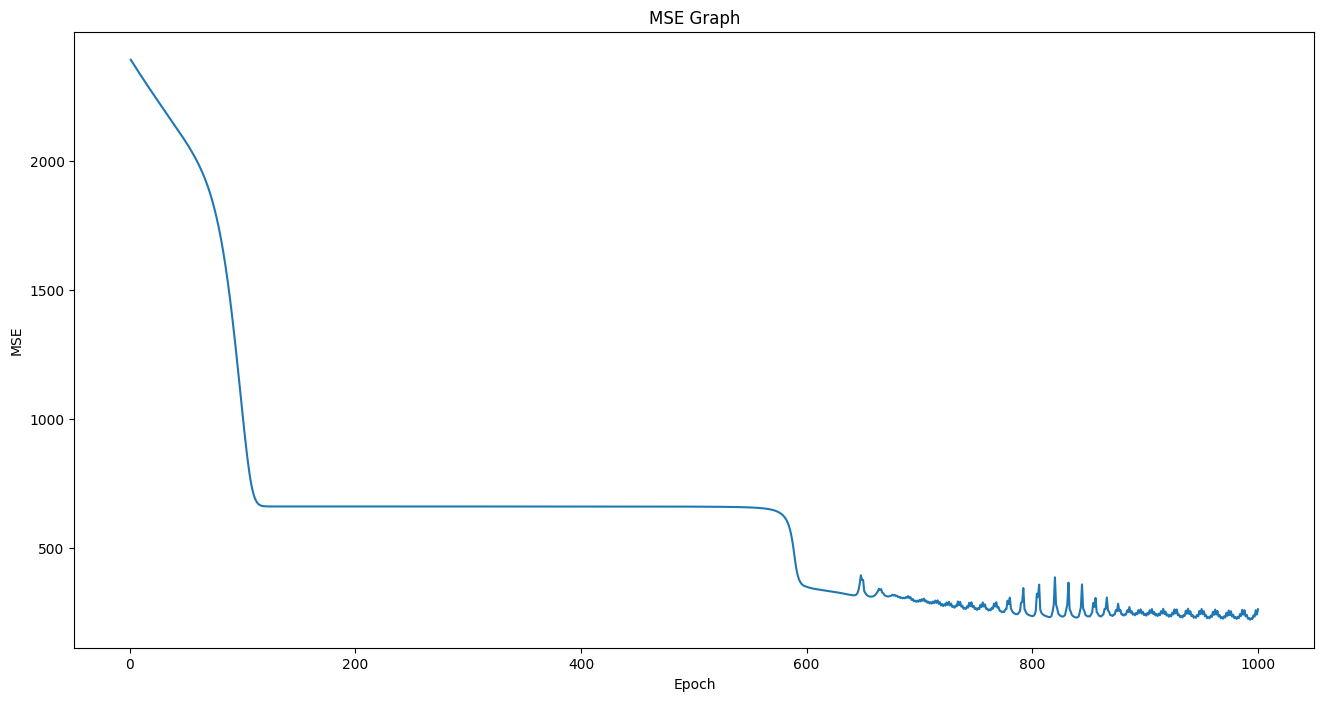

In [30]:
x =  [i + 1 for i in range(history.__len__())]
# # Plot the data
plt.figure(figsize=(16, 8))
plt.plot(x, history)
plt.title('MSE Graph')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.show()


In [31]:
y_pred = model.predict(X_test)

In [32]:
for i in range(X_train.shape[0]):
    print('Predicted:', (model.predict(X_train.iloc[i])).squeeze(),'Target:', y_train.iloc[i])

Predicted: 56.35811822403278 Target: 66.41
Predicted: 55.603558295790535 Target: 47.51
Predicted: 23.77070774525688 Target: 43.86
Predicted: 7.942295571669273 Target: 3.26
Predicted: 55.452172233796965 Target: 66.94
Predicted: 55.51895951692566 Target: 61.71
Predicted: 54.31211590593297 Target: 65.52
Predicted: 13.727731605008287 Target: 0.18
Predicted: 29.180217186655227 Target: 43.45
Predicted: 55.90699056359409 Target: 64.89
Predicted: 62.230216161274804 Target: 67.42
Predicted: 54.508566955024556 Target: 70.57
Predicted: 62.18045476403876 Target: 59.54
Predicted: 28.00345379983263 Target: 18.64
Predicted: 44.96755715964643 Target: 15.8
Predicted: 63.71232526972163 Target: 49.55
Predicted: 54.83151255001802 Target: 44.28
Predicted: 7.98763003654654 Target: 3.58
Predicted: 7.944591407801501 Target: 3.55
Predicted: 23.027390567765984 Target: 59.51
Predicted: 49.187881332269804 Target: 14.31
Predicted: 39.99532595490008 Target: 47.02
Predicted: 53.60464738754889 Target: 68.46
Predicted

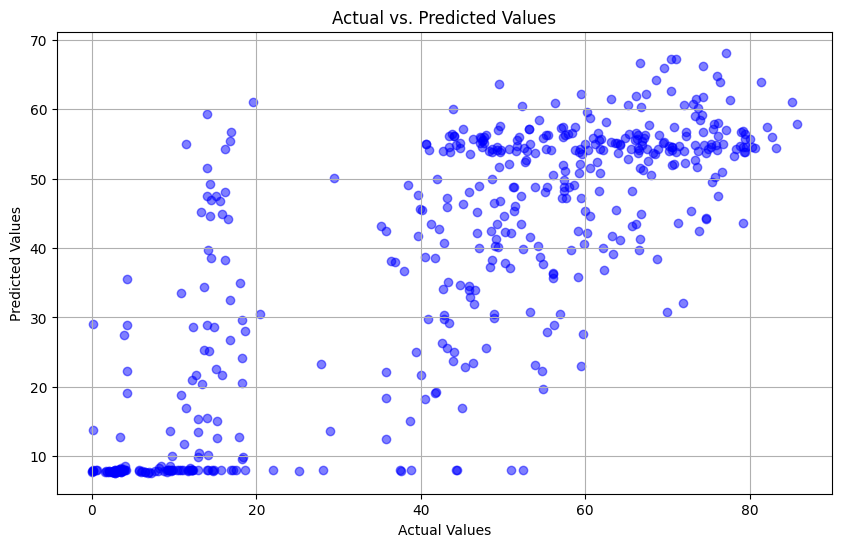

In [33]:

# Assuming y_train is your target values
y_pred_train = [model.predict(X_train.iloc[i]).squeeze() for i in range(X_train.shape[0])]


# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(y_train, y_pred_train, color='blue', alpha=0.5)
plt.title('Actual vs. Predicted Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid(True)
plt.show()


In [34]:
evaluate_model(model,history,X_test,y_test,'ANN')

ANN
R-squared (R²): 0.4969479296717364
Fraction of Variance Unexplained (FSD): 0.5237511260920767
Fractional Bias (FA2): 0.4715836022046857
Nash-Sutcliffe Efficiency (NSE): 0.4969479296717364
Mean Squared Error (MSE): 339.0305449544962
Root Mean Squared Error (RMSE): 18.412782107940565
Mean Absolute Error (MAE): 14.488247164992854
